In [1]:
import pandas as pd
import re
import numpy as np
import scipy
import itertools
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from collections import Counter
from random import choice

In [2]:
# Storing the training and test datasets into their respective dataframes
trained = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# **Preprocessing**

In [3]:
trained['Tweet'] = trained['Tweet'].str.lower() # Ensuring all words in the Tweet column of training data are lowercased
test['Tweet'] = test['Tweet'].str.lower() # Ensuring all words in the Tweet column of test data are lowercased

In [4]:
# Parsing the stop_words.txt file and storing all the words in a list.
stopwords = []
with open('stop_words.txt','r') as file:    
    for line in file:         
        for word in line.split():            
            stopwords.append(word) 

In [5]:
# Removing all stopwords from all the tweets in training data.
trained["Tweet"] = trained["Tweet"].apply(lambda func: ' '.join(sw 
                                          for sw in func.split() 
                                          if sw not in stopwords))

# Removing all stopwords from all the tweets in test data.
test["Tweet"] = test["Tweet"].apply(lambda func: ' '.join(sw 
                                          for sw in func.split() 
                                          if sw not in stopwords))
trained.head()

,Sentiment,Tweet
0,neutral,"@united 877 amsterdam ewr, 02.27.2015, 737-300."
1,negative,@united it-problems link? #3thparty
2,positive,@united -today staff @ msp took customer servi...
3,negative,@americanair yet receive assistance one agents...
4,negative,@southwestair let change reservation online wa...


In [6]:
#List of all special characters that are to be removed.
special_chars = ["!",'"',"%","&","amp","'","(",")", "*","+",",","-",".",
                 "/",":",";","<","=",">","?","[","\\","]","^","_",
                 "`","{","|","}","~","–","@","#","$"]

In [7]:
#Training Data
trained['Tweet'] = trained['Tweet'].str.replace(r'http?://[^\s<>"]+|www\.[^\s<>"]+', '') # Removing hyperlinks from all the tweets. They are not needed for classification.
trained['Tweet'] = trained['Tweet'].str.replace('@[A-Za-z0-9]+', '') # Removing usernames from all the tweets.
trained['Tweet'] = trained['Tweet'].str.replace(r'\B#\w*[a-zA-Z]+\w*', '') # Removing hashtags, including the text, from all the tweets. Hashtags are useless since their words cannot be splitted with spaces.
trained['Tweet'] = trained['Tweet'].str.replace('\d+', '') # Removing numbers from all the tweets. They will not assist in any way to improve the classification process.

for c in special_chars:
    trained['Tweet'] = trained['Tweet'].str.replace(c,'') # Removing all special characters from all the tweets

#Test Data
test['Tweet'] = test['Tweet'].str.replace(r'http?://[^\s<>"]+|www\.[^\s<>"]+', '') # Removing hyperlinks from all the tweets
test['Tweet'] = test['Tweet'].str.replace('@[A-Za-z0-9]+', '') # Removing usernames from all the tweets.
test['Tweet'] = test['Tweet'].str.replace(r'\B#\w*[a-zA-Z]+\w*', '') # Removing hashtags, including the text, from all the tweets
test['Tweet'] = test['Tweet'].str.replace('\d+', '') # Removing numbers from all the tweets

for c in special_chars:
    test['Tweet'] = test['Tweet'].str.replace(c,'') # Removing all special characters from all the tweets

In [8]:
trained.head()

,Sentiment,Tweet
0,neutral,amsterdam ewr
1,negative,itproblems link
2,positive,today staff msp took customer service new le...
3,negative,yet receive assistance one agents securing ne...
4,negative,let change reservation online wasting time


In [9]:
test.head()

,Sentiment,Tweet
0,neutral,jump dallasaustin market news
1,positive,chicago seen seat a aa far great ride pdx
2,negative,need bag bouncer get together
3,negative,hey jetblue stranded entire plane supposed go...
4,negative,big fail curbside baggage pittsburgh charge ...


In [10]:
#Training Data
train_unique = (list(set(trained['Tweet'].str.findall("\w+").sum()))) # Finding all the unique words in training data's Tweet column
train_unique_words = len(train_unique)

#Test Data
test_unique = (list(set(test['Tweet'].str.findall("\w+").sum()))) # Finding all the unique words in test data's Tweet column
test_unique_words = len(test_unique)

print("Unique words in Training Data: {}".format(train_unique_words))
print("Unique words in Test Data: {}".format(test_unique_words))

Unique words in Training Data: 10033
Unique words in Test Data: 4839


## **Feature Extraction**

In [11]:
#Training Data
train_matrix = [] # Forming a 2D matrix to store all training feature vectors

#Test Data
test_matrix = [] # Forming a 2D matrix to store all test feature vectors

In [12]:
#Training Data: Extracting features and storing them into the training feature matrix
for sentence in trained['Tweet']:
    train_featurevec = []
    word = sentence.split()
    for w in train_unique:
        train_featurevec.append(word.count(w))
    train_matrix.append(train_featurevec)

#Test Data: Extracting features and storing them into the test feature matrix
for sentence in test['Tweet']:
    test_featurevec = []
    word = sentence.split()
    for w in train_unique:
        test_featurevec.append(word.count(w))
    test_matrix.append(test_featurevec)

In [13]:
print("Shape of Training Matrix: ({0} , {1})".format(len(train_matrix),len(train_matrix[0])))
print("Shape of Test Matrix: ({0} , {1})".format(len(test_matrix),len(test_matrix[0])))

Shape of Training Matrix: (11680 , 10033)
Shape of Test Matrix: (2921 , 10033)


# **Part 1**

In [14]:
#Calculating distances between every test instance with all the train instances. This returns a 2D distances vector.
dists = cdist(test_matrix,train_matrix,'euclidean') 

In [15]:
#Making an empty column in our test data for predicted labels.
test['Predicted Label'] = ''
dists.shape

(2921, 11680)

In [16]:
#Function that takes a list and returns the mode of the list. If there are more than one modes, it randomly selects any of them.
def get_mode(l):
    counting = Counter(l)
    max_count = max(counting.values())
    return choice([ks for ks in counting if counting[ks] == max_count])


## **K Nearest Neighbors & Performance Measures**

In [17]:
# Making a general structure of our confusion matrix
cmatrix = pd.DataFrame({'Gold Positive': '', 'Gold Neutral': '', 'Gold Negative': ''},
                       index = ['Predicted Positive','Predicted Neutral','Predicted Negative'])

# Lists that will later store respective values for plotting
accuracy_list = []
recall_list = []
precision_list = []
F1_list = []

In [18]:
def cmatrix_measures(k,dists,test,cmatrix):

  row_count = 0
  first_max = 0
  second_max = 0
  check_tie = False

  for ls in dists:
    sorted_distances_indices = np.argsort(ls) #Getting a sorted list of indices of all distances in ls with the smallest distance's index at 0th position
    knn_indices = []
    knn_indices = list(itertools.islice(sorted_distances_indices,k)) #Extracting the indices of the k-smallest distances

    knn_labels = []
    for i in knn_indices:
      label = trained['Sentiment'][i] #Extracting the label of the instance by indexing it through the DataFrame.
      knn_labels.append(label) #Appending the label to our labels list.

    max_class = get_mode(knn_labels)
    first_max = max_class
    second_max = max(knn_labels)
    if first_max == second_max:
      check_tie = True
    predicted_label = max_class
    test['Predicted Label'][row_count] = predicted_label

    row_count += 1

  #Creating a frequency DataFrame that will store value counts for each tuple of instances. E.g (positive,positive = 309) and so on for all other seven instances.
  testfreqdf = test.groupby(["Sentiment", "Predicted Label"]).size().reset_index(name="Frequency")
  testfreqdf

  #Extracting values from the Frequency DataFrame and assigning to specific cells in the confusion matrix.
  cmatrix['Gold Positive']['Predicted Positive'] = testfreqdf['Frequency'][8]
  cmatrix['Gold Neutral']['Predicted Positive'] = testfreqdf['Frequency'][5]
  cmatrix['Gold Negative']['Predicted Positive'] = testfreqdf['Frequency'][2]
  cmatrix['Gold Positive']['Predicted Neutral'] = testfreqdf['Frequency'][7]
  cmatrix['Gold Neutral']['Predicted Neutral'] = testfreqdf['Frequency'][4]
  cmatrix['Gold Negative']['Predicted Neutral'] = testfreqdf['Frequency'][1]
  cmatrix['Gold Positive']['Predicted Negative'] = testfreqdf['Frequency'][6]
  cmatrix['Gold Neutral']['Predicted Negative'] = testfreqdf['Frequency'][3]
  cmatrix['Gold Negative']['Predicted Negative'] = testfreqdf['Frequency'][0]

  #Extracting all three True Positives from the matrix to measure accuracy.
  TP = cmatrix['Gold Positive']['Predicted Positive']
  TNT = cmatrix['Gold Neutral']['Predicted Neutral']
  TN = cmatrix['Gold Negative']['Predicted Negative']
  total = testfreqdf['Frequency'].sum()
  accuracy = ((TP+TNT+TN)/total)*100
  accuracy = round(accuracy,2)
  accuracy_list.append(accuracy)

  #Extracting all recalls from the matrix to measure macroaveraged recall.
  recall_pos = cmatrix['Gold Positive']['Predicted Positive']/cmatrix['Gold Positive'].sum()
  recall_neut = cmatrix['Gold Neutral']['Predicted Neutral']/cmatrix['Gold Neutral'].sum()
  recall_neg = cmatrix['Gold Negative']['Predicted Negative']/cmatrix['Gold Negative'].sum()
  macroaveraged_recall = ((recall_pos+recall_neut+recall_neg)/3)*100
  macroaveraged_recall = round(macroaveraged_recall,2)
  recall_list.append(macroaveraged_recall)

  #Extracting all precisions from the matrix to measure macroaveraged precision.
  precision_pos = cmatrix['Gold Positive']['Predicted Positive']/(cmatrix.iloc[0,0:3].sum())
  precision_neut = cmatrix['Gold Neutral']['Predicted Neutral']/(cmatrix.iloc[1,0:3].sum())
  precision_neg = cmatrix['Gold Negative']['Predicted Negative']/(cmatrix.iloc[2,0:3].sum())
  macroaveraged_precision = ((precision_pos+precision_neut+precision_neg)/3)*100
  macroaveraged_precision = round(macroaveraged_precision,2)
  precision_list.append(macroaveraged_precision)

  #Extracting all F1_scores from the matrix to measure macroaveraged F1_score.
  F1_pos = (2*precision_pos*recall_pos)/(precision_pos+recall_pos)
  F1_neut = (2*precision_neut*recall_neut)/(precision_neut+recall_neut)
  F1_neg = (2*precision_neg*recall_neg)/(precision_neg+recall_neg)
  F1_score = ((F1_pos + F1_neut + F1_neg)/3)*100  
  F1_score = round(F1_score,2)
  F1_list.append(F1_score)
  

  print("\n\nConfusion Matrix with k = {}:\n".format(k))
  print(cmatrix)
  print("\nAccuracy with k = {0}: {1}%".format(k,accuracy))
  print("Macroaveraged Precision with k = {0}: {1}%".format(k,macroaveraged_precision))
  print("Macroaveraged Recall with k = {0}: {1}%".format(k,macroaveraged_recall))
  print("Macroaveraged F1-score with k = {0}: {1}%".format(k,F1_score))

In [19]:
#Calling the function for each individual k
cmatrix_measures(1,dists,test,cmatrix)
cmatrix_measures(3,dists,test,cmatrix)
cmatrix_measures(5,dists,test,cmatrix)
cmatrix_measures(7,dists,test,cmatrix)
cmatrix_measures(10,dists,test,cmatrix)



Confusion Matrix with k = 1:

                   Gold Positive Gold Neutral Gold Negative
Predicted Positive           265           90           188
Predicted Neutral            152          409           801
Predicted Negative            55          116           845

Accuracy with k = 1: 52.0%
Macroaveraged Precision with k = 1: 54.0%
Macroaveraged Recall with k = 1: 56.24%
Macroaveraged F1-score with k = 1: 50.96%


Confusion Matrix with k = 3:

                   Gold Positive Gold Neutral Gold Negative
Predicted Positive           282          102           190
Predicted Neutral            145          419           865
Predicted Negative            45           94           779

Accuracy with k = 3: 50.67%
Macroaveraged Precision with k = 3: 54.44%
Macroaveraged Recall with k = 3: 56.78%
Macroaveraged F1-score with k = 3: 50.51%


Confusion Matrix with k = 5:

                   Gold Positive Gold Neutral Gold Negative
Predicted Positive           286          101           19

# **Plotting (Part-1)**

<function matplotlib.pyplot.show>

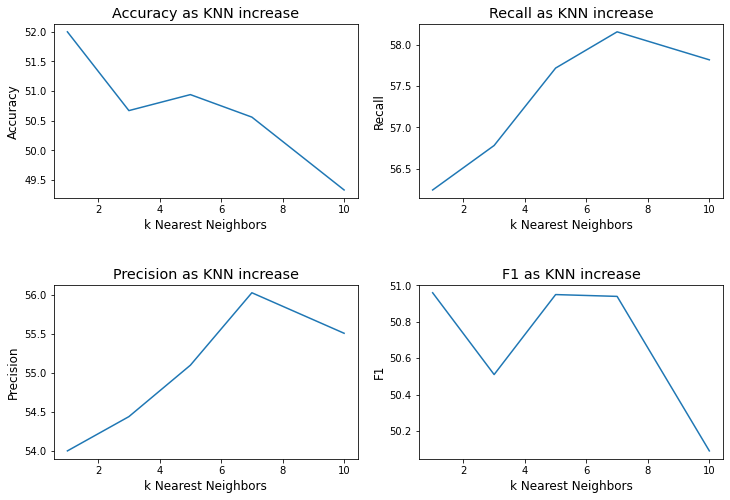

In [20]:
k_list = [1,3,5,7,10] 

fig = plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(k_list,accuracy_list)
plt.title("Accuracy as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Accuracy",fontsize='large')

plt.subplot(2,2,2)
plt.plot(k_list,recall_list)
plt.title("Recall as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Recall",fontsize='large')

plt.subplot(2,2,3)
plt.plot(k_list,precision_list)
plt.title("Precision as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Precision",fontsize='large')

plt.subplot(2,2,4)
plt.plot(k_list,F1_list)
plt.title("F1 as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("F1",fontsize='large')

fig.subplots_adjust(hspace=.5)

plt.show

# **Part 2**

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
#Initializing lists to be used in plotting later.
acc_list = []
rec_list = []
prec_list = []
f1_list = []

# **KNN & Performance Measures with SKLearn**

In [23]:
def classifying(trainfeatures,testfeatures):

  X_train = trainfeatures #train_matrix - 2D feature vector
  X_test = testfeatures #test_matrix - 2D feature vector
  y_train = trained.iloc[:,0].values #trained['Sentiment]
  y_test = test.iloc[:,0].values #test['Sentiment]

  for k in [1,3,5,7,10]:

    classifier = KNeighborsClassifier(n_neighbors=k,algorithm='brute') #Using brute-force algorithm for quicker computation.
    classifier.fit(X_train, y_train) #Fitting the built-in sklearn classifier on our training data
    predicted_label = classifier.predict(X_test) #Making the classifier to predict on the previously unseen test data.

    accuracy_score = (metrics.accuracy_score(y_test,predicted_label))
    accuracy_score = (round(accuracy_score,2))*100
    acc_list.append(accuracy_score)

    confusion_mat = confusion_matrix(y_test, predicted_label)
    class_report = classification_report(y_test, predicted_label)

    macro_precision = (metrics.precision_score(y_test, predicted_label, average='macro'))
    macro_precision = (round(macro_precision,2))*100
    prec_list.append(macro_precision)

    macro_recall = (metrics.recall_score(y_test, predicted_label, average='macro'))
    macro_recall = (round(macro_recall,2))*100
    rec_list.append(macro_recall)
    
    macro_f1 = (metrics.f1_score(y_test, predicted_label, average='macro'))
    macro_f1 = (round(macro_f1,2))*100
    f1_list.append(macro_f1)

    print("\n\nConfusion Matrix for k = {} is:\n".format(k))
    print(confusion_mat)
    print("\nClassification Report for k = {} is:\n".format(k))
    print(class_report)
    print("Accuracy Score for k = {0} is: {1}%".format(k,accuracy_score))
    print("Macroaveraged Recall for k = {0} is: {1}%".format(k,macro_recall))
    print("Macroaveraged Precision for k = {0} is: {1}%".format(k,macro_precision))
    print("Macroaveraged F1-score for k = {0} is: {1}%".format(k,macro_f1))

In [24]:
classifying(train_matrix,test_matrix)



Confusion Matrix for k = 1 is:

[[873 773 188]
 [122 416  77]
 [ 69 180 223]]

Classification Report for k = 1 is:

              precision    recall  f1-score   support

    negative       0.82      0.48      0.60      1834
     neutral       0.30      0.68      0.42       615
    positive       0.46      0.47      0.46       472

    accuracy                           0.52      2921
   macro avg       0.53      0.54      0.50      2921
weighted avg       0.65      0.52      0.54      2921

Accuracy Score for k = 1 is: 52.0%
Macroaveraged Recall for k = 1 is: 54.0%
Macroaveraged Precision for k = 1 is: 53.0%
Macroaveraged F1-score for k = 1 is: 50.0%


Confusion Matrix for k = 3 is:

[[905 801 128]
 [126 425  64]
 [ 71 168 233]]

Classification Report for k = 3 is:

              precision    recall  f1-score   support

    negative       0.82      0.49      0.62      1834
     neutral       0.30      0.69      0.42       615
    positive       0.55      0.49      0.52       472

  

# **Plotting (Part-2)**

<function matplotlib.pyplot.show>

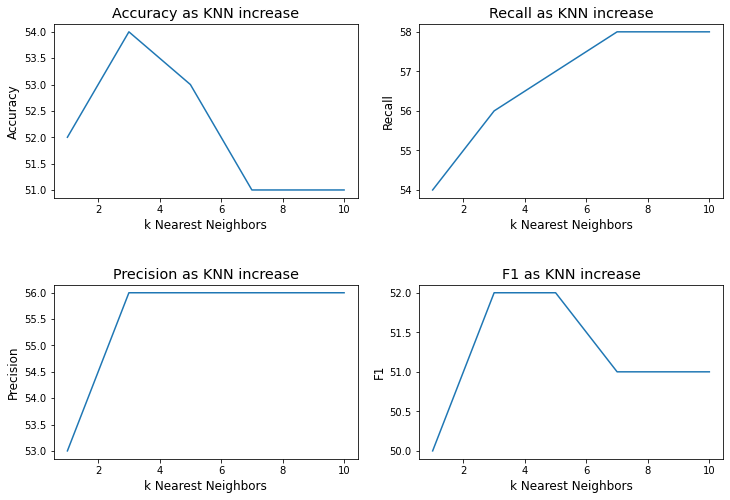

In [25]:
k_ls = [1,3,5,7,10] 

fig = plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(k_ls,acc_list)
plt.title("Accuracy as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Accuracy",fontsize='large')

plt.subplot(2,2,2)
plt.plot(k_ls,rec_list)
plt.title("Recall as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Recall",fontsize='large')

plt.subplot(2,2,3)
plt.plot(k_ls,prec_list)
plt.title("Precision as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("Precision",fontsize='large')

plt.subplot(2,2,4)
plt.plot(k_ls,f1_list)
plt.title("F1 as KNN increase",fontsize='x-large')
plt.xlabel("k Nearest Neighbors",fontsize='large')
plt.ylabel("F1",fontsize='large')

fig.subplots_adjust(hspace=.5)

plt.show